Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback, set_seed
from datasets import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import our modules
import sys
import os

utils_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'utils'))
models_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))

if utils_path not in sys.path:
    sys.path.insert(0, utils_path)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from general_utils import load_data, prepare_all_samples, get_entity_date_pairs, calculate_metrics
from bert_training_utils import create_training_pairs, handle_class_imbalance, add_special_tokens, tokenize_function, compute_metrics, build_gold_lookup, get_label_for_pair
from bert_extractor_utils import preprocess_input, bert_extraction, mark_entities_full_text
from bert_model import BertRC

Data Loading

In [2]:
# Load data
df = load_data("../data/training_dataset.csv")
print(f"Loaded {len(df)} records")

Loaded 5 records


In [3]:
#Inspect df
df.head()

,doc_id,note_text,entities_json,dates_json,relative_dates_json,relations_json
0,26461,Ultrasound (30nd Jun 2024): no significant fin...,"[{'id': 308244, 'value': 'history of meningiti...","[{'id': 308320, 'value': '30nd Jun 2024', 'sta...",[],"[{'date': '12nd Sep 2024', 'entity': 'pituitar..."
1,26462,Labs (27th Sep 2024): anemia. resolving Skin:...,"[{'id': 308371, 'value': 'lesions', 'cui': '52...","[{'id': 308581, 'value': '22/11/24', 'start': ...",[],"[{'date': '27th Sep 2024', 'entity': 'anemia',..."
2,26463,URGENT REVIEW (2024-10-04): cough. suspect ost...,"[{'id': 308886, 'value': 'frequent urination',...","[{'id': 308940, 'value': '2024-10-04', 'start'...",[],"[{'date': '2024-10-04', 'entity': 'cough', 'da..."
3,26464,URGENT REVIEW (13rd Feb 2025) MRI of the brain...,"[{'id': 308951, 'value': 'multiple_sclerosis',...","[{'id': 308996, 'value': '05-03-2025', 'start'...",[],"[{'date': '13rd Feb 2025', 'entity': 'visual',..."
4,26465,New pt((18/11/24)): pt presents with nausea/vo...,"[{'id': 308998, 'value': 'history of neoplasm ...","[{'id': 309070, 'value': '18/11/24', 'start': ...",[],"[{'date': '18/11/24', 'entity': 'nausea/vomiti..."


In [4]:
# Prepare all samples
samples = prepare_all_samples(df)
print(f"Prepared {len(samples)} samples")
#samples[0]

Prepared 5 samples


Model & Data Preparation for Finetuning

In [5]:
# Set seed for reproducibility
set_seed(42)

In [6]:
#Set path to save model
model_save_path = '../models/bert_models/'

In [7]:
#Choose model to use - any BERT model from HuggingFace can be used, see: https://huggingface.co/google-bert
model_name = "google/bert_uncased_L-2_H-128_A-2"

In [8]:
# Load base model and tokenizer
#base_tokenizer = AutoTokenizer.from_pretrained(model_name)
#base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

In [9]:
# Create training pairs
processed_df = create_training_pairs(samples)
print(f"\nCreated {len(processed_df)} training pairs")


Created 741 training pairs


In [10]:
# Handle class imbalance
balanced_df, class_weights = handle_class_imbalance(processed_df, method='weighted')
print(f"Class weights: {class_weights}")

Class weights: tensor([0.1188, 1.8812])


In [11]:
# Train-test split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['label'])
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 592, Test: 149


In [12]:
# Setup tokenizer with special tokens
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = add_special_tokens(tokenizer)

In [13]:
# Resize model embeddings to match new tokenizer size
#base_model.resize_token_embeddings(len(tokenizer))

In [14]:
# Prepare PyTorch datasets
train_dataset = Dataset.from_pandas(train_df[['marked_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['marked_text', 'label']])

In [15]:
# Tokenize
train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer, max_length=256), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x, tokenizer, max_length=256), batched=True)

Map:   0%|          | 0/592 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

In [16]:
# Set format for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

BERT Finetuning

In [17]:
# Create custom model with span pooling
model = BertRC(
    model_name=model_name,
    tokenizer=tokenizer,
    num_labels=2,
    class_weights=class_weights
)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [18]:
print(type(model))

<class 'bert_model.BertRC'>


In [19]:
# Resize model embeddings to match new tokenizer size
#model.backbone.resize_token_embeddings(len(tokenizer))

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir=model_save_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=50,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=10,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to=[],
    seed=42,
)

In [21]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

C:\Users\Satyam\AppData\Local\Temp\ipykernel_10964\2186443392.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
#Train
trainer.train()

c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,F1 Weighted
1,0.613400,0.774583,0.892617,0.526984,0.892617,0.892617
2,0.681500,0.957847,0.906040,0.537677,0.906040,0.900501
3,0.683300,1.220777,0.906040,0.537677,0.906040,0.900501
4,0.788500,1.390188,0.906040,0.537677,0.906040,0.900501


c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=296, training_loss=0.6968366648699786, metrics={'train_runtime': 48.8676, 'train_samples_per_second': 121.144, 'train_steps_per_second': 15.143, 'total_flos': 0.0, 'train_loss': 0.6968366648699786, 'epoch': 4.0})

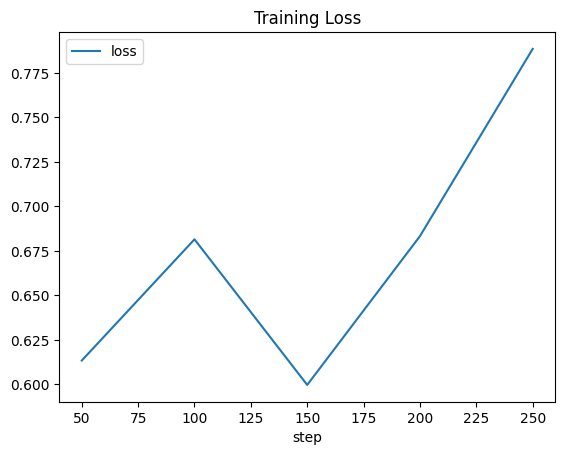

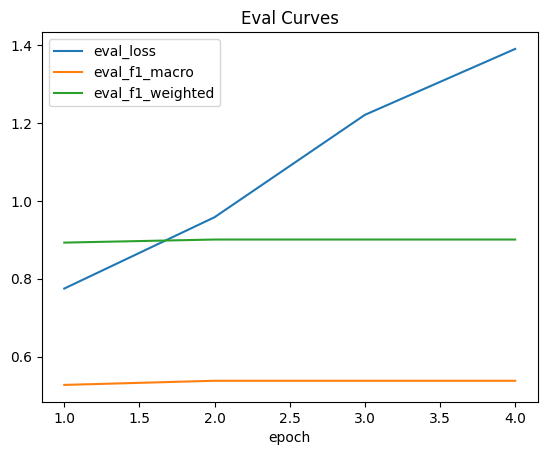

In [23]:
#Loss and training curves
logs = pd.DataFrame(trainer.state.log_history)

# Training loss per step
train_loss = logs[logs.loss.notna()][["step","loss"]]
train_loss.plot(x="step", y="loss", title="Training Loss"); plt.show()

# Eval loss/metrics per eval
eval_logs = logs[logs.eval_loss.notna()][["epoch","eval_loss","eval_accuracy","eval_f1_macro","eval_f1_weighted"]]
eval_logs.plot(x="epoch", y=["eval_loss","eval_f1_macro","eval_f1_weighted"], title="Eval Curves"); plt.show()

In [24]:
# Evaluate on test set
eval_results = trainer.evaluate(test_tokenized)
print("\nTest Results:")
for metric, value in eval_results.items():
    if not metric.startswith('eval_'):
        continue
    clean_metric = metric.replace('eval_', '')
    print(f"{clean_metric}: {value:.4f}")

c:\Users\Satyam\Downloads\pituitary_adenoma\venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Test Results:
loss: 0.9578
accuracy: 0.9060
f1_macro: 0.5377
f1_micro: 0.9060
f1_weighted: 0.9005
runtime: 0.4671
samples_per_second: 319.0150
steps_per_second: 21.4100


In [25]:
# Save the final model
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to ../models/bert_models/
